## 使用Scikit-Learn实现葡萄酒数据集的分类

In [1]:
import seaborn as sns

sns.set_theme()

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

wine_dataset = load_wine()
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    wine_dataset.data, wine_dataset.target, test_size=0.2, random_state=0
)

### 比较预测结果与真实结果

In [3]:
import pandas as pd
import numpy as np

sk_decision_tree_classifier = DecisionTreeClassifier()
sk_decision_tree_classifier.fit(X_train_wine, y_train_wine)
wine_predict_result = sk_decision_tree_classifier.predict(X_test_wine)
comparsion_data = np.hstack(
    [wine_predict_result.reshape(-1, 1), y_test_wine.reshape(-1, 1)]
)
comparsion_table = pd.DataFrame(data=comparsion_data, columns=["Predicted", "Actual"])
comparsion_table.head()

,Predicted,Actual
0,0,0
1,2,2
2,1,1
3,0,0
4,1,1


### 比较不同算法的差别

In [4]:
sk_decision_tree_classifier.score(X_test_wine, y_test_wine)

0.9722222222222222

In [5]:
sk_entropy_dt_classifier = DecisionTreeClassifier(criterion="entropy")
sk_entropy_dt_classifier.fit(X_train_wine, y_train_wine).score(X_test_wine, y_test_wine)

0.9166666666666666

### 信息熵/Gini

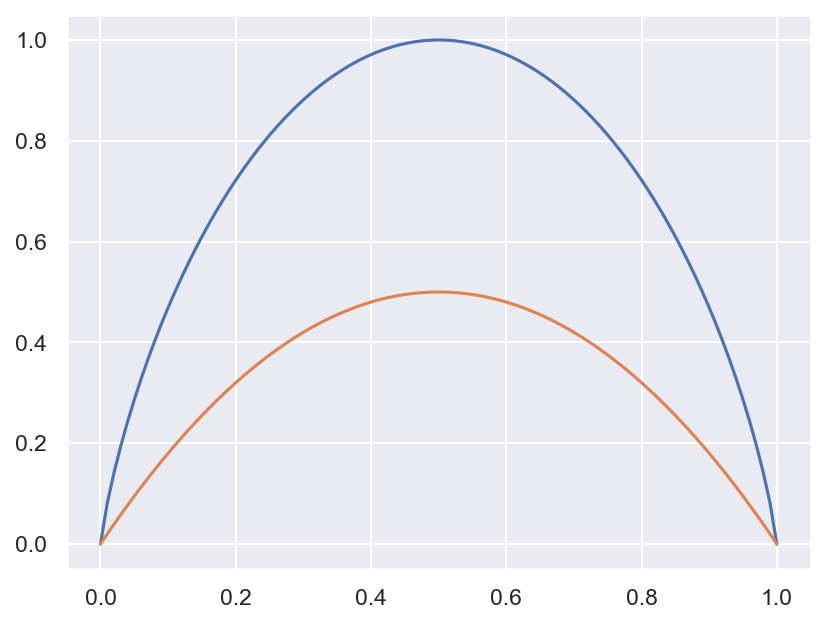

In [6]:
import matplotlib.pyplot as plt

p1 = np.linspace(0.0, 1.0, 100)


def entropy(pi):
    if pi == 0 or pi == 1:
        return 0
    return -(pi * np.log2(pi) + (1 - pi) * np.log2(1 - pi))


def gini(pi):
    return 1 - (pi**2 + (1 - pi) ** 2)


y_entropy = list(map(entropy, p1))
y_gini = list(map(gini, p1))
plt.figure(dpi=150)
plt.plot(p1, y_entropy)
plt.plot(p1, y_gini)
plt.show()

In [7]:
wb_features = ["Outlook", "Temp", "Humidity", "Windy"]
wb_dataset = np.array(
    [
        ["Sunny", "Hot", "High", "Weak", "No"],
        ["Sunny", "Hot", "High", "Strong", "No"],
        ["Overcast", "Hot", "High", "Weak", "Yes"],
        ["Rain", "Mild", "High", "Weak", "Yes"],
        ["Rain", "Cool", "Normal", "Weak", "Yes"],
        ["Rain", "Cool", "Normal", "Strong", "No"],
        ["Overcast", "Cool", "Normal", "Strong", "Yes"],
        ["Sunny", "Mild", "High", "Weak", "No"],
        ["Sunny", "Cool", "Normal", "Weak", "Yes"],
        ["Rain", "Mild", "Normal", "Weak", "Yes"],
        ["Sunny", "Mild", "Normal", "Strong", "Yes"],
        ["Overcast", "Mild", "High", "Strong", "Yes"],
        ["Overcast", "Hot", "Normal", "Weak", "Yes"],
        ["Rain", "Mild", "High", "Strong", "No"],
    ]
)

In [8]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

X_train_wb = wb_dataset[:, :4]
y_train_wb = wb_dataset[:, 4]
category_orders = [
    ["Sunny", "Overcast", "Rain"],
    ["Cool", "Mild", "Hot"],
    ["Normal", "High"],
    ["Weak", "Strong"],
]
wb_pipeline = Pipeline(
    [
        ("encoder", OrdinalEncoder(categories=category_orders)),
        ("classifier", DecisionTreeClassifier()),
    ]
)
wb_to_predict = np.array([["Rain", "Hot", "High", "Weak"]])
wb_pipeline.fit(X_train_wb, y_train_wb).predict(wb_to_predict)

array(['Yes'], dtype='<U8')

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_is_fitted
from typing import Self, NamedTuple, Union


class ID3DecisionTreeBranchNode:
    future_index: int
    children: dict[float, any]

    def __init__(self, feature_index):
        self.feature_index = feature_index
        self.children = {}


class ID3DecisionTreeLeafNode:
    label: any

    def __init__(self, label):
        self.label = label


ID3DecisionTreeNode = Union[ID3DecisionTreeBranchNode, ID3DecisionTreeLeafNode]


class DatasetPartition(NamedTuple):
    feature_index: int
    value: float
    X_subset: np.ndarray
    y_subset: np.ndarray


class MyID3DecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        X, y = check_X_y(X, y, dtype=None)
        features = list(range(X.shape[1]))
        self.decision_tree_ = self.__build_decision_tree(X, y, features)
        return self

    def __build_decision_tree(
        self, X: np.ndarray, y: np.ndarray, features: list[int]
    ) -> ID3DecisionTreeNode:
        # 如果所有样本的标签相同，则返回叶子节点
        if np.all(y == y[0]):
            return ID3DecisionTreeLeafNode(label=y[0])

        # 如果没有特征可供划分，则返回叶子节点
        if len(features) == 0:
            return ID3DecisionTreeLeafNode(label=self.__find_most_frequent_label(y))

        best_feature, best_partitions = self.__find_best_split_feature(X, y, features)
        tree_node = ID3DecisionTreeBranchNode(feature_index=best_feature)

        for _, value, X_subset, y_subset in best_partitions:
            rest_features = [feature for feature in features if feature != best_feature]
            tree_node.children[value] = self.__build_decision_tree(
                X_subset, y_subset, rest_features
            )

        return tree_node

    def __find_most_frequent_label(self, y: np.ndarray) -> int:
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]

    def __find_best_split_feature(self, X: np.ndarray, y, features: list[int]) -> int:
        if len(features) == 0:
            raise ValueError("No feature to split")

        max_gain = 0
        best_feature = None
        best_partitions = None

        for feature in features:
            partitions = self.__split_data(X, y, feature)
            ent_gain = self.__ent_gain(y, partitions)
            if ent_gain > max_gain:
                max_gain = ent_gain
                best_feature = feature
                best_partitions = partitions

        return best_feature, best_partitions

    def __ent_gain(self, y: np.ndarray, partitions: list[DatasetPartition]) -> float:
        ent_before = self.__ent(y)
        ent_after = sum(
            map(
                lambda p: len(p.y_subset) / len(y) * self.__ent(p.y_subset),
                partitions,
            )
        )

        return ent_before - ent_after

    def __split_data(
        self, X: np.ndarray, y: np.ndarray, feature: int
    ) -> list[DatasetPartition]:
        feature_values = np.unique(X[:, feature])
        return [
            DatasetPartition(
                feature_index=feature,
                value=value,
                X_subset=X[X[:, feature] == value],
                y_subset=y[X[:, feature] == value],
            )
            for value in feature_values
        ]

    def __ent(self, y: np.ndarray) -> float:
        labels, counts = np.unique(y, return_counts=True)
        ps = counts / len(y)
        return -np.sum(ps * np.log2(ps, where=ps != 0))

    def predict(self, X: np.ndarray):
        check_is_fitted(self)
        return np.apply_along_axis(self.__predict_single, 1, X, self.decision_tree_)

    def __predict_single(
        self,
        X: np.ndarray,
        tree_node: ID3DecisionTreeNode,
    ):
        match tree_node:
            case ID3DecisionTreeLeafNode(label=label):
                return label
            case ID3DecisionTreeBranchNode(
                feature_index=feature_index, children=children
            ):
                value = X[feature_index]
                return self.__predict_single(X, children[value])

In [10]:
wb_pipeline_id3 = Pipeline(
    [
        ("encoder", OrdinalEncoder(categories=category_orders)),
        ("classifier", MyID3DecisionTreeClassifier()),
    ]
)

wb_pipeline_id3.fit(X_train_wb, y_train_wb)


Pipeline(steps=[('encoder',
                 OrdinalEncoder(categories=[['Sunny', 'Overcast', 'Rain'],
                                            ['Cool', 'Mild', 'Hot'],
                                            ['Normal', 'High'],
                                            ['Weak', 'Strong']])),
                ('classifier', MyID3DecisionTreeClassifier())])

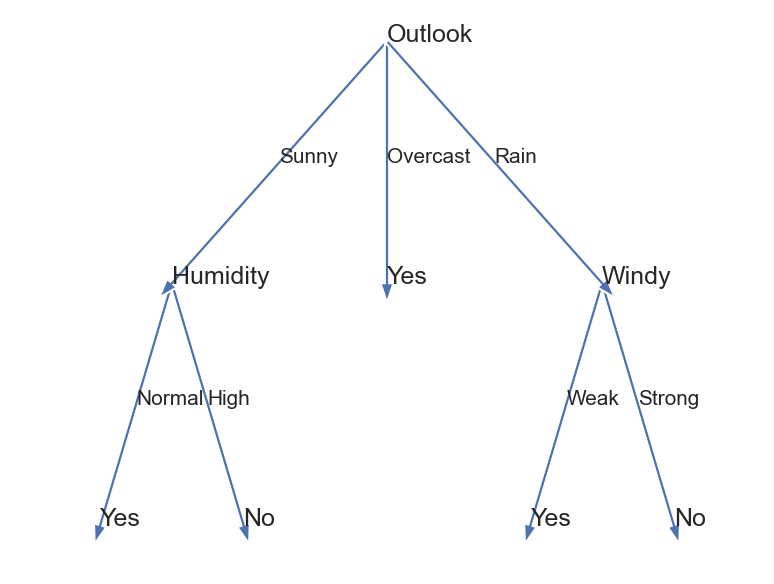

In [11]:
def plot_id3_decision_tree(root, feature_names, feature_values):
    plt.figure(dpi=150)
    plot_id3_decision_tree_impl(root, feature_names, feature_values, 0.1, 0.9, 0.95)
    plt.axis("equal")
    plt.axis("off")
    plt.show()


def plot_id3_decision_tree_impl(
    root, feature_names, feature_values, left_bound, right_bound, y_postion, y_step=0.45
):
    center = (left_bound + right_bound) / 2
    current_x = center
    current_y = y_postion
    match root:
        case ID3DecisionTreeLeafNode(label=label):
            plt.text(current_x, current_y, label)

        case ID3DecisionTreeBranchNode(feature_index=feature_index, children=children):
            plt.text(current_x, current_y, feature_names[root.feature_index])

            children_spacing = (right_bound - left_bound) / len(children)
            children_plotting_positions = np.linspace(
                left_bound, right_bound, len(children)
            )

            for index, (value, child) in enumerate(children.items()):
                lb = children_plotting_positions[index] - children_spacing / 2
                rb = children_plotting_positions[index] + children_spacing / 2
                child_x, child_y = plot_id3_decision_tree_impl(
                    child,
                    feature_names,
                    feature_values,
                    lb,
                    rb,
                    y_postion - y_step,
                    y_step,
                )
                plt.arrow(
                    current_x,
                    current_y,
                    child_x - current_x,
                    child_y - current_y,
                    width=0.008,
                )

                line_center_x = (current_x + child_x) / 2
                line_center_y = (current_y + child_y) / 2

                plt.text(
                    line_center_x,
                    line_center_y,
                    feature_values[feature_index][np.int64(value)],
                    fontsize=10,
                )

    return current_x, current_y


id3_decision_tree = wb_pipeline_id3.named_steps["classifier"].decision_tree_
plot_id3_decision_tree(id3_decision_tree, wb_features, category_orders)

In [12]:
wb_pipeline_id3.predict(wb_to_predict)

array(['Yes'], dtype='<U3')

In [13]:
class CARTDecisionTreeBranchNode:
    feature_index: int
    split_value: float
    children: dict[str, any]

    def __init__(self, feature_index, split_value):
        self.feature_index = feature_index
        self.split_value = split_value
        self.children = {}


class CARTDecisionTreeLeafNode:
    label: any

    def __init__(self, label):
        self.label = label


CARTDecisionTreeNode = Union[CARTDecisionTreeBranchNode, CARTDecisionTreeLeafNode]


class MyCARTDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        check_X_y(X, y)
        feature_value_pairs = [
            (feature, value)
            for feature in range(X.shape[1])
            for value in self.__get_feature_values(X, feature)
        ]
        self.decision_tree_ = self.__build_decision_tree(X, y, feature_value_pairs)
        return self

    def __build_decision_tree(
        self, X: np.ndarray, y: np.ndarray, fv_pairs: list[tuple[int, int]]
    ) -> CARTDecisionTreeNode:
        if np.all(y == y[0]):
            return CARTDecisionTreeLeafNode(label=y[0])

        if len(fv_pairs) == 0:
            return CARTDecisionTreeLeafNode(label=self.__find_most_frequent_label(y))

        best_feature, best_value = self.__find_best_split_feature_value(X, y, fv_pairs)
        tree_node = CARTDecisionTreeBranchNode(
            feature_index=best_feature, split_value=best_value
        )

        X_eq, y_eq, X_neq, y_neq = self.__split_data(X, y, best_feature, best_value)
        next_fv_pairs = [
            fv for fv in fv_pairs if fv[0] != best_feature or fv[1] != best_value
        ]
        tree_node.children["eq"] = self.__build_decision_tree(X_eq, y_eq, next_fv_pairs)
        tree_node.children["neq"] = self.__build_decision_tree(
            X_neq, y_neq, next_fv_pairs
        )

        return tree_node

    def __find_best_split_feature_value(
        self, X: np.ndarray, y: np.ndarray, fv_pairs: list[tuple[int, int]]
    ) -> tuple[int, int]:
        purest_feature_value = min(
            fv_pairs,
            key=lambda pair: self.__gini_splitted(X, y, pair[0], pair[1]),
        )
        return purest_feature_value

    def __gini_splitted(
        self, X: np.ndarray, y: np.ndarray, feature: int, value: int
    ) -> float:
        count = len(y)
        X1, y1, X2, y2 = self.__split_data(X, y, feature, value)
        count1 = len(y1)
        count2 = len(y2)
        gini1 = self.__gini(y1)
        gini2 = self.__gini(y2)
        return count1 / count * gini1 + count2 / count * gini2

    def __get_feature_values(self, X: np.ndarray, feature: int) -> np.ndarray:
        values = np.unique(X[:, feature])
        return values

    def __split_data(self, X: np.ndarray, y: np.ndarray, feature: int, value: int):
        indexes_eq = np.where(X[:, feature] == value)
        indexes_neq = np.where(X[:, feature] != value)
        return X[indexes_eq], y[indexes_eq], X[indexes_neq], y[indexes_neq]

    def __find_most_frequent_label(self, y: np.ndarray) -> int:
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]

    def __gini(self, y: np.ndarray) -> float:
        labels, counts = np.unique(y, return_counts=True)
        ps = counts / len(y)
        return 1 - np.sum(ps**2)

    def predict(self, X: np.ndarray) -> np.ndarray:
        check_is_fitted(self)
        return np.apply_along_axis(self.__predict_single, 1, X, self.decision_tree_)

    def __predict_single(
        self,
        X: np.ndarray,
        tree_node: CARTDecisionTreeNode,
    ) -> any:
        match tree_node:
            case CARTDecisionTreeLeafNode(label=label):
                return label
            case CARTDecisionTreeBranchNode(
                feature_index=feature_index, split_value=split_value, children=children
            ):
                value = X[feature_index]
                child_key = "eq" if value == split_value else "neq"
                return self.__predict_single(X, children[child_key])

In [14]:
wb_pipeline_cart = Pipeline(
    [
        ("encoder", OrdinalEncoder(categories=category_orders)),
        ("classifier", MyCARTDecisionTreeClassifier()),
    ]
)

wb_pipeline_cart.fit(X_train_wb, y_train_wb)


Pipeline(steps=[('encoder',
                 OrdinalEncoder(categories=[['Sunny', 'Overcast', 'Rain'],
                                            ['Cool', 'Mild', 'Hot'],
                                            ['Normal', 'High'],
                                            ['Weak', 'Strong']])),
                ('classifier', MyCARTDecisionTreeClassifier())])

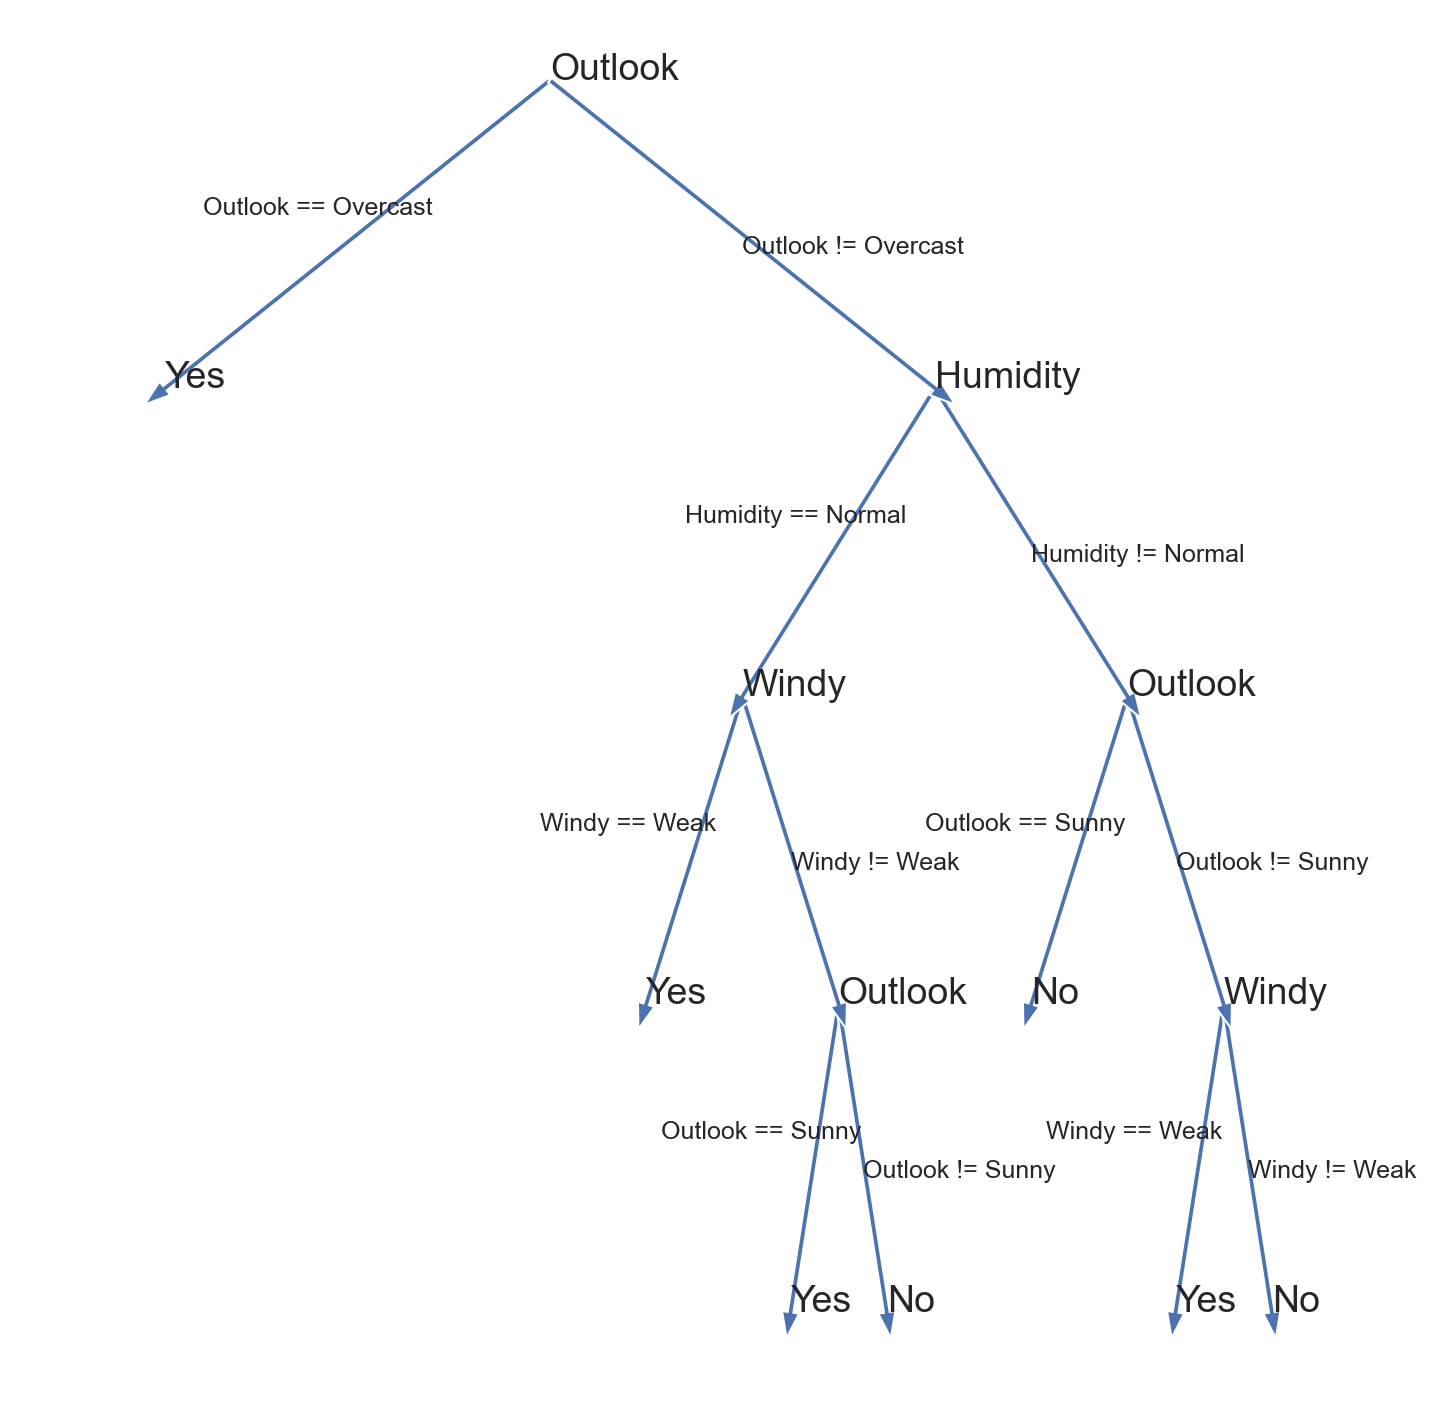

In [15]:
def plot_cart_decision_tree(root, feature_names, feature_values):
    plt.figure(figsize=(12, 12), dpi=150)
    plot_cart_decision_tree_impl(
        root, feature_names, feature_values, 0, 2, 0.95, y_step=0.8
    )
    plt.axis("equal")
    plt.axis("off")
    plt.show()


def plot_cart_decision_tree_impl(
    root, feature_names, feature_values, left_bound, right_bound, y_postion, y_step=0.7
):
    center = (left_bound + right_bound) / 2
    current_x = center
    current_y = y_postion
    match root:
        case CARTDecisionTreeLeafNode(label=label):
            plt.text(current_x, current_y, label, fontsize=18)
        case CARTDecisionTreeBranchNode(
            feature_index=feature_index, split_value=split_value, children=children
        ):
            plt.text(
                current_x, current_y, feature_names[root.feature_index], fontsize=18
            )
            children_spacing = (right_bound - left_bound) / len(children)
            children_plotting_positions = np.linspace(
                left_bound, right_bound, len(children)
            )
            for index, (condition, child) in enumerate(children.items()):
                lb = children_plotting_positions[index] - children_spacing / 2
                rb = children_plotting_positions[index] + children_spacing / 2
                child_x, child_y = plot_cart_decision_tree_impl(
                    child,
                    feature_names,
                    feature_values,
                    lb,
                    rb,
                    y_postion - y_step,
                    y_step,
                )
                plt.arrow(
                    current_x,
                    current_y,
                    child_x - current_x,
                    child_y - current_y,
                    width=0.015,
                )
                line_center_x = (current_x + child_x) / 2
                line_center_y = (current_y + child_y) / 2
                split_value_name = feature_values[feature_index][np.int64(split_value)]
                feature_name = feature_names[feature_index]
                operator = "==" if condition == "eq" else "!="
                # Add a offset to avoid overlapping
                if condition == "eq":
                    line_center_x -= 0.4
                    line_center_y += 0.05
                else:
                    line_center_y -= 0.05

                plt.text(
                    line_center_x,
                    line_center_y,
                    f"{feature_name} {operator} {split_value_name}",
                    fontsize=12,
                )
    return current_x, current_y


cart_decision_tree = wb_pipeline_cart.named_steps["classifier"].decision_tree_
plot_cart_decision_tree(cart_decision_tree, wb_features, category_orders)

In [16]:
wb_pipeline_cart.predict(wb_to_predict)

array(['Yes'], dtype='<U3')